# Price Sensitivity simulation with Torch
## multi-arm contextual bandit

In [1]:
import jax
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.jit
import torch.distributions.normal as normal
import torch.distributions.uniform as uniform
import torch.distributions.beta as beta

from torch_models import LogisticRegression
from torch_agent import Agent, QAgent
from LangevinMC_Optimizer import LangevinMC
from functools import partial

/home/cdsw/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Random seed to make our experiment replicable 
SEED = 142

# Number of visitors we want to simulate
NUM_VISITS = 8000

PRICE_LIST = torch.arange(0, 1, 0.05)
FEATURE_SPACE = torch.tensor([[0, 1], [1, 0]], dtype=torch.float32)
PRICE_SENSITIVITY_PARMS = torch.tensor([[0.3,0.05], [0.5,0.1]], dtype=torch.float32)

In [3]:
def X_hist_init(n_feat):
    """
    Returns the initial history array.
    """
    return torch.empty(size=(0, n_feat + 1), dtype=torch.float32)

def y_hist_init():
    """
    Returns the initial history array.
    """
    return torch.empty(size=(0, 1), dtype=torch.float32)

def regret_hist_init():
    """
    Returns the initial history array.
    """
    return torch.empty(size=(0, 1), dtype=torch.float32)

def reward_hist_init():
    """
    Returns the initial history array.
    """
    return torch.empty(size=(0, 1), dtype=torch.float32)

In [4]:
def crossover_learning(X, sold, price, price_list):
    
    if sold:
        relevant_prices = price_list[price_list <= price]
    else:
        relevant_prices = price_list[price_list >= price]

    stacked_X = torch.stack([X] * len(relevant_prices), dim=0)
    X = torch.cat((stacked_X, relevant_prices.unsqueeze(1)), dim=1)
    y = sold.expand(len(relevant_prices),1)

    return X, y.float()

In [5]:
def reward_fn(price):
    # turnover/profit genrated from sale
    return price

In [6]:
def visit(state, timestep, feature_list, price_list, price_sensitivity_params, agent):
    """
    Simulates a user visit.
    """

    # Unpacking the experiment state
    X_hist, y_hist, regret_hist, reward_hist = state
    torch.manual_seed(timestep)

    # simulate client type
    client_group = torch.randint(low=0, high=feature_list.shape[0], size=(1,))[0].item()

    # Selecting the variant to show the user, based on
    # the given policy, the agent's paramters, and the current timestep
    price = agent.choose_price(feature_list[client_group], client_group, price_list)
    
    # Calculate Optimal Price
    exp_reward = (1 - normal.Normal(price_sensitivity_params[client_group][0], price_sensitivity_params[client_group][1]).cdf(price_list)) * reward_fn(price_list)
    optimal_price_index = torch.argmax(exp_reward)
    optimal_price = price_list[optimal_price_index]
    
    # regret
    regret = torch.abs(optimal_price - price)

    # Generate random normal number
    random_normal = torch.randn(1)  # Replace with the desired shape

    # Calculate client_price_limit
    client_price_limit = price_sensitivity_params[client_group][0] + price_sensitivity_params[client_group][1] * random_normal

    # Check if sold
    sold = client_price_limit >= price

    # reward
    reward = price*sold
    
    # perform cross-over learning observation simulation
    X_co, y_co = crossover_learning(feature_list[client_group], sold, price, price_list)
    # appending prices to feature space
    X_hist = torch.cat((X_hist, X_co), dim=0)
    y_hist = torch.cat((y_hist, y_co), dim=0)
    regret_hist = torch.cat((regret_hist, regret.view(1, 1)), dim=0)
    reward_hist = torch.cat((reward_hist, reward.view(1, 1)), dim=0)
    
    # Calculating the agent's updated parameters, based on
    # the current parameters, the price that was offered,
    # and whether or not the client accepted
    agent.update_model(client_group, price, sold, price_list, X=X_co, y=y_co, num_iter=5)
 
    return (X_hist, y_hist, regret_hist, reward_hist)

## Implementing the policies 

In [7]:
agent1 = Agent(
    base_model = LogisticRegression(len(FEATURE_SPACE)+1, 1),
    optimizer = partial(torch.optim.Adam, lr=0.05),
    criterion = torch.nn.BCEWithLogitsLoss(),
    explore_first = 0
)

agent2 = Agent(
    base_model = LogisticRegression(len(FEATURE_SPACE)+1, 1),
    optimizer = partial(torch.optim.Adam, lr=0.01),
    criterion = torch.nn.BCEWithLogitsLoss(),
    explore_first = 0
)

agent3 = Agent(
    base_model = LogisticRegression(len(FEATURE_SPACE)+1, 1),
    optimizer = partial(torch.optim.Adam, lr=0.05),
    criterion = torch.nn.BCEWithLogitsLoss(),
    epsilon = 0.1,
    explore_first = 0
)

agent4 = Agent(
    base_model = LogisticRegression(len(FEATURE_SPACE)+1, 1),
    optimizer = partial(torch.optim.SGD, lr=0.05),
    criterion = torch.nn.BCEWithLogitsLoss(),
    explore_first = 0
)

agent5 = QAgent(
    context_space = FEATURE_SPACE,
    price_list = PRICE_LIST,
    epsilon = 0.1,               
    policy = "Epsilon Greedy",
    explore_first = 0
    )

agent6 = QAgent(
    context_space = FEATURE_SPACE,
    price_list = PRICE_LIST,
    epsilon = 0.1,               
    policy = "Thompson Sampling",
    explore_first = 0
    )

In [8]:
# Langevin MC Thompson Sampling (see https://arxiv.org/pdf/2206.11254.pdf)
agent7 = Agent(
    base_model = LogisticRegression(len(FEATURE_SPACE)+1, 1),
    optimizer = partial(LangevinMC,weight_decay=0.0, lr = 0.05),
    criterion = torch.nn.BCEWithLogitsLoss(),
    explore_first = 0
)

/home/cdsw/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Implementing the evaluation

In [9]:
from functools import partial
from matplotlib import pyplot as plt

In [10]:
def evaluate(agent):
    """
    Simulating the experiment for NUM_VISITS users
    while accumulating the sales history
    """
    # Initial values
    init_state = (X_hist_init(len(FEATURE_SPACE)),
                  y_hist_init(),
                  regret_hist_init(),
                  reward_hist_init()
                 )
    # Reset model weights
    agent.clear()
    
    state = init_state
    for timestep in range(1, NUM_VISITS + 1):
        state = visit(state, timestep, 
                      feature_list = FEATURE_SPACE, 
                      price_list = PRICE_LIST, 
                      price_sensitivity_params = PRICE_SENSITIVITY_PARMS, 
                      agent = agent)
    return state

In [11]:
(agent1_X_hist, agent1_y_hist, agent1_regret_hist, agent1_reward_hist) = evaluate(
    agent=agent1
)

(agent2_X_hist, agent2_y_hist, agent2_regret_hist, agent2_reward_hist) = evaluate(
    agent=agent2
)

(agent3_X_hist, agent3_y_hist, agent3_regret_hist, agent3_reward_hist) = evaluate(
    agent=agent3
)

(agent4_X_hist, agent4_y_hist, agent4_regret_hist, agent4_reward_hist) = evaluate(
    agent=agent4
)

(agent5_X_hist, agent5_y_hist, agent5_regret_hist, agent5_reward_hist) = evaluate(
    agent=agent5
)

(agent6_X_hist, agent6_y_hist, agent6_regret_hist, agent6_reward_hist) = evaluate(
    agent=agent6
)

(agent7_X_hist, agent7_y_hist, agent7_regret_hist, agent7_reward_hist) = evaluate(
    agent=agent7
)

def cum_avg(tensor):
    cumulative_sum = tensor.cumsum(dim=0).squeeze()
    cumulative_average = cumulative_sum / torch.arange(1, cumulative_sum.size(0) + 1, dtype=torch.float32)
    return cumulative_average

cum_avg_regret_agent1 = cum_avg(agent1_regret_hist)
cum_avg_reward_agent1 = cum_avg(agent1_reward_hist)
cum_avg_regret_agent2 = cum_avg(agent2_regret_hist)
cum_avg_reward_agent2 = cum_avg(agent2_reward_hist)
cum_avg_regret_agent3 = cum_avg(agent3_regret_hist)
cum_avg_reward_agent3 = cum_avg(agent3_reward_hist)
cum_avg_regret_agent4 = cum_avg(agent4_regret_hist)
cum_avg_reward_agent4 = cum_avg(agent4_reward_hist)
cum_avg_regret_agent5 = cum_avg(agent5_regret_hist)
cum_avg_reward_agent5 = cum_avg(agent5_reward_hist)
cum_avg_regret_agent6 = cum_avg(agent6_regret_hist)
cum_avg_reward_agent6 = cum_avg(agent6_reward_hist)
cum_avg_regret_agent7 = cum_avg(agent7_regret_hist)
cum_avg_reward_agent7 = cum_avg(agent7_reward_hist)

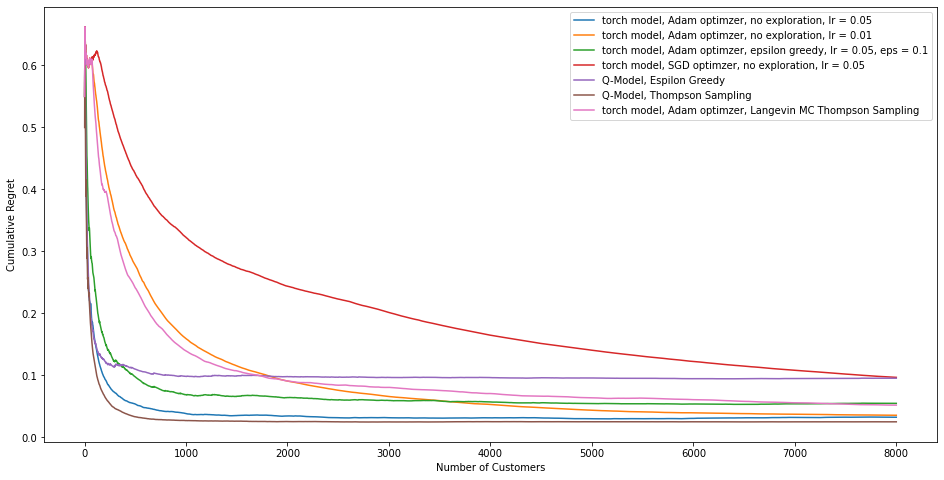

In [12]:
# Visualisation
fig, ax = plt.subplots(figsize=(16, 8))

x = torch.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of Customers')
ax.set_ylabel('Cumulative Regret')

ax.plot(x, cum_avg_regret_agent1, label='torch model, Adam optimzer, no exploration, lr = 0.05')
ax.plot(x, cum_avg_regret_agent2, label='torch model, Adam optimzer, no exploration, lr = 0.01')
ax.plot(x, cum_avg_regret_agent3, label='torch model, Adam optimzer, epsilon greedy, lr = 0.05, eps = 0.1')
ax.plot(x, cum_avg_regret_agent4, label='torch model, SGD optimzer, no exploration, lr = 0.05')
ax.plot(x, cum_avg_regret_agent5, label='Q-Model, Espilon Greedy')
ax.plot(x, cum_avg_regret_agent6, label='Q-Model, Thompson Sampling')
ax.plot(x, cum_avg_regret_agent7, label='torch model, Adam optimzer, Langevin MC Thompson Sampling')

plt.legend()
plt.savefig("output/policy_regret_comparison_torchagent_explorefirst.png")
plt.show()

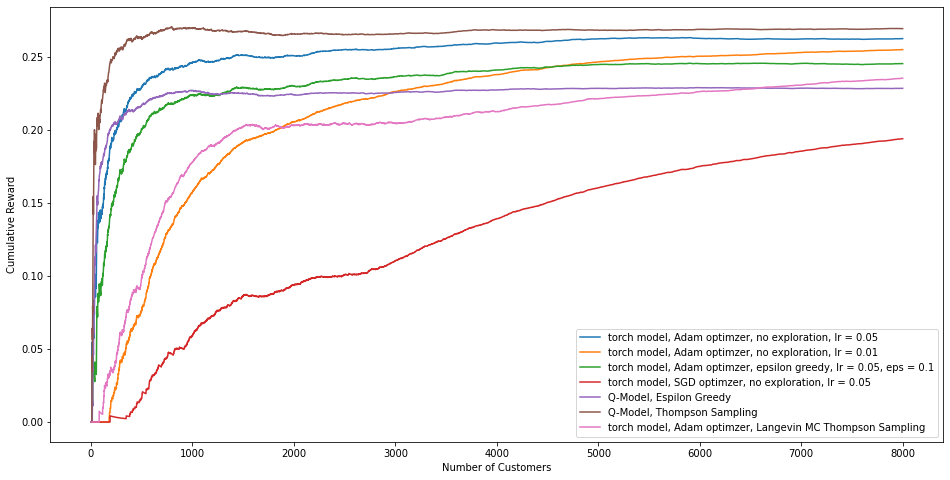

In [13]:
# Visualisation
fig, ax = plt.subplots(figsize=(16, 8))

x = torch.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of Customers')
ax.set_ylabel('Cumulative Reward')

ax.plot(x, cum_avg_reward_agent1, label='torch model, Adam optimzer, no exploration, lr = 0.05')
ax.plot(x, cum_avg_reward_agent2, label='torch model, Adam optimzer, no exploration, lr = 0.01')
ax.plot(x, cum_avg_reward_agent3, label='torch model, Adam optimzer, epsilon greedy, lr = 0.05, eps = 0.1')
ax.plot(x, cum_avg_reward_agent4, label='torch model, SGD optimzer, no exploration, lr = 0.05')
ax.plot(x, cum_avg_reward_agent5, label='Q-Model, Espilon Greedy')
ax.plot(x, cum_avg_reward_agent6, label='Q-Model, Thompson Sampling')
ax.plot(x, cum_avg_reward_agent7, label='torch model, Adam optimzer, Langevin MC Thompson Sampling')

plt.legend()
plt.savefig("output/policy_reward_comparison_torchagent_explorefirst.png")
plt.show()